# Fixed Parameters in `simpple` Models

As shown in previous tutorials, `simpple` model parameters are defined directly as distributions.
However, sometimes, we build a model and would like to test it with only a subset of its parameters.
In such cases, re-building the entire model is unnecessarily complicated, and freezing certain parameters is preferable.
To enable fixed parameters, `simpple` provides a `Fixed` distributions, which is basically a delta function centered on a given parameter value.
To keep samplign efficient, these fixed parameters are not treated in the same way as other parameters:

- During initialization, `model.fixed_p` and `model.vary_p` are created under the hood to separated fixed and variable parameters.
- Fixed parameters are not included in `model.ndim`
- Fixed parameters are not included in `model.keys()` by default. They will be included with `model.keys(fixed=True)`
- When calling `model.log_likelihood()`, `model.log_prob()` and `model.forward()`, they can optionally be included, but are not required. If they are not included, the fixed value is used.
- When calling `model.log_prior()` and `model.prior_transform()`, they are ignored.
- When calling `model.log_prior()` and `model.prior_transform()`, `model.nautilus_priors()`, they are ignored.

We will explore this functionality below with a simple sinusoidal model.

## Simulated Data

We will first simulate sinuoidal data that we will fit with a simple forward model.

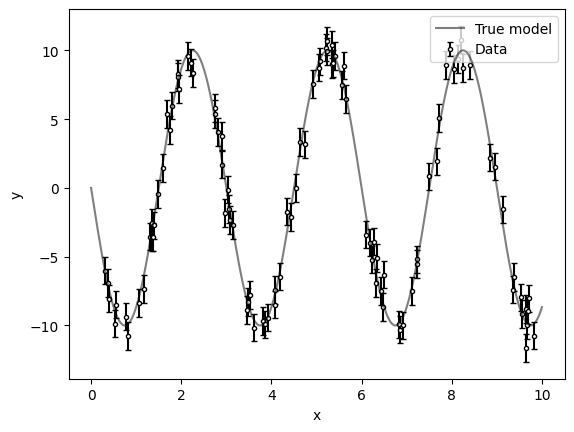

In [1]:
import numpy as np
import matplotlib.pyplot as plt

rng = np.random.default_rng(819)


def forward_sine(p: dict, x: np.ndarray) -> np.ndarray:
    return p["A"] * np.sin(2 * np.pi * x / p["P"] - p["phi"])


p_true = {
    "A": 10.0,
    "P": 3.0,
    "phi": np.pi,
}

x = np.sort(rng.uniform(low=0.0, high=10.0, size=100))
x_mod = np.linspace(0.0, 10.0, num=1000)
y_true = forward_sine(p_true, x)
y_true_mod = forward_sine(p_true, x_mod)

yerr = 1
y = y_true + yerr * rng.normal(size=x.size)


def plot_data():
    plt.plot(x_mod, y_true_mod, "k", alpha=0.5, zorder=10000, label="True model")
    plt.errorbar(x, y, yerr=yerr, label="Data", fmt="k.", mfc="w", capsize=2)
    plt.legend(loc=1)
    plt.xlabel("x")
    plt.ylabel("y")


plot_data()
plt.show()

## `simpple` Model without Fixed Parameters

First, we will fit the data with a fully variable model where none of the sinusoidal parameters are fixed.
This is very similar to the [line-fitting tutorial](./fitting-a-line.ipynb) tutorial, but with a different forward model.

We first build our `simpple` model and test it with fixed values.

In [2]:
from simpple.model import ForwardModel
import simpple.distributions as sdist


def log_likelihood(
    p: dict, x: np.ndarray, y: np.ndarray, yerr: np.ndarray
) -> np.ndarray:
    ymod = forward_sine(p, x)
    s2 = yerr**2
    return -0.5 * np.sum(np.log(2 * np.pi * s2) + (y - ymod) ** 2 / s2)


parameters = {
    "A": sdist.LogUniform(1e-4, 1e2),
    "P": sdist.LogUniform(1e-1, 1e1),
    "phi": sdist.Uniform(0, 2 * np.pi),
}
model = ForwardModel(parameters, log_likelihood, forward_sine)

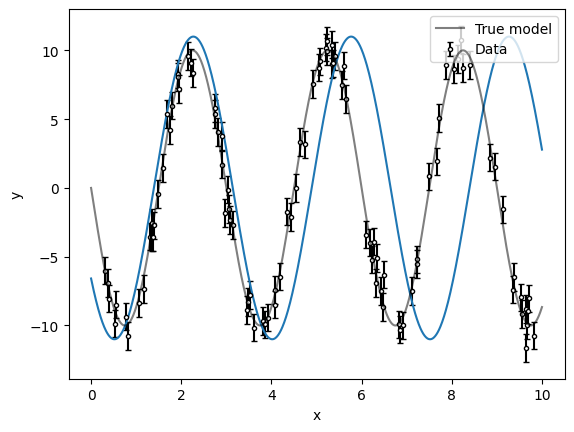

In [3]:
test_p = {"A": 11.0, "P": 3.5, "phi": 2.5}

plot_data()
plt.plot(x_mod, model.forward(test_p, x_mod), label="Test model")
plt.show()

## Sampling of the Model without Fixed Parameters

Now that we have a working model, we can sample the parameters with MCMC or nested sampling.
Here will use emcee to keep things simple.

In [4]:
import emcee

nwalkers = 50
nsteps = 5000
sampler = emcee.EnsembleSampler(nwalkers, model.ndim, model.log_prob, args=(x, y, yerr))

In [5]:
p0 = np.array(list(test_p.values())) + 1e-4 * rng.normal(size=(nwalkers, model.ndim))
_ = sampler.run_mcmc(p0, nsteps, progress="notebook")

  0%|          | 0/5000 [00:00<?, ?it/s]

Let us have a look at the chains and the posterior samples, both in parameter space and in model predictions.

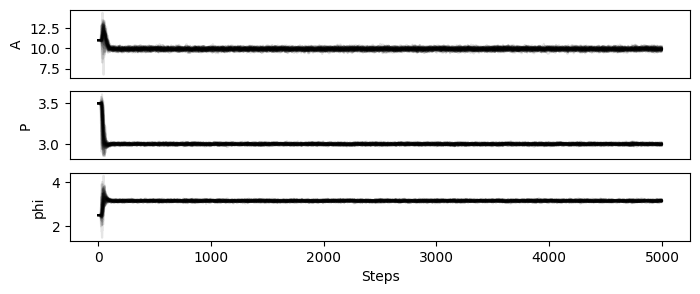

In [6]:
from simpple.plot import chainplot

chainplot(sampler.get_chain(), labels=model.keys())
plt.show()

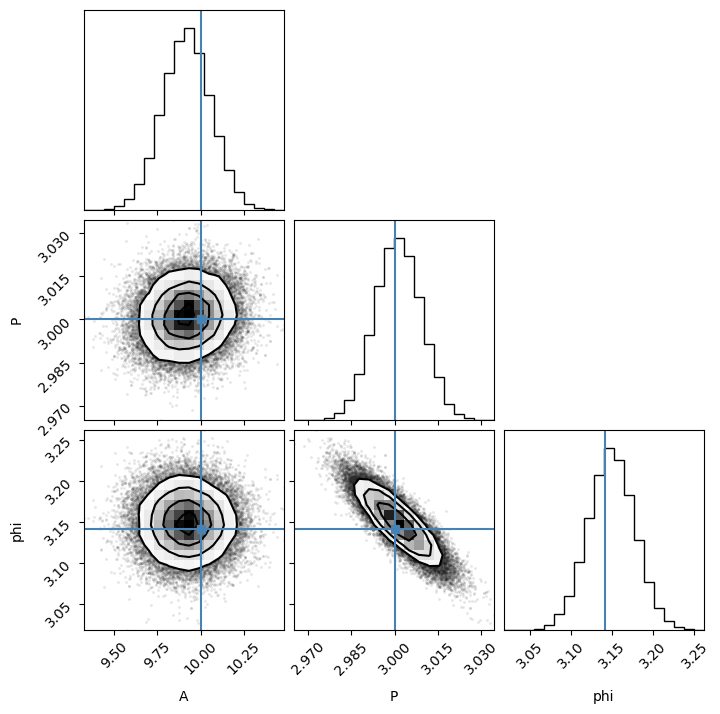

In [7]:
import corner

chain = sampler.get_chain(flat=True, discard=1000, thin=5)
corner.corner(chain, labels=model.keys(), truths=list(p_true.values()))
plt.show()

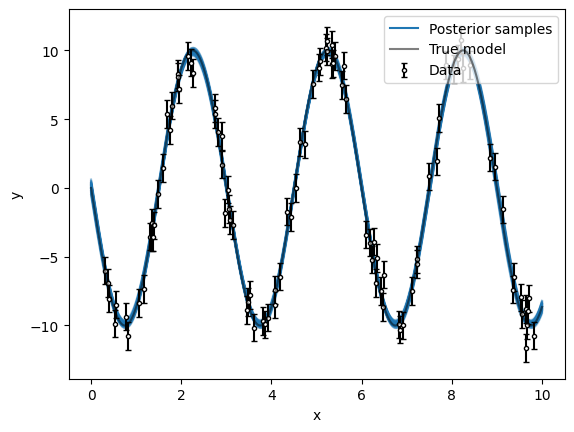

In [8]:
pred_samples = model.get_posterior_pred(chain.T, 100, x_mod)
plt.plot(x_mod, pred_samples[0], "C0-", label="Posterior samples")
plt.plot(x_mod, pred_samples[1:].T, "C0-", alpha=0.2)
plot_data()
plt.show()

## Model with Fixed Parameters

Let us say that for some reason, we want to keep one of the parameters fixed.
Maybe we have an extremely good constraint from another dataset or we want to test wether a model comparison favors this parameter as fixed or variable.

For a simple model like the one used in this tutorial, we could easily re-write the model with one of the parameters fixed.
However, as we build more complicated models, re-writing them every time we wish to freeze a parameters quickly becomes inconvenient.

As mentioned above, using the `Fixed` distribution will freeze specific parameters in our model.
For example, in the model we fix the phase to its true value.

In [9]:
parameters_fix = {
    "A": sdist.LogUniform(1e-4, 1e2),
    "P": sdist.LogUniform(1e-1, 1e1),
    "phi": sdist.Fixed(np.pi),
}
model_fix = ForwardModel(parameters_fix, log_likelihood, forward_sine)

As explained above, the number of dimensions and the keys of the model will not account for the fixed parameter.

In [10]:
print("Keys of the fixed phase model:", model_fix.keys())
print("Keys of the fixed phase model (including fixed):", model_fix.keys(fixed=True))
print("ndim of the fixed phase model:", model_fix.ndim)

Keys of the fixed phase model: ['A', 'P']
Keys of the fixed phase model (including fixed): ['A', 'P', 'phi']
ndim of the fixed phase model: 2


There are also two extra dictionaries, `fixed_p ` and `vary_p`, which are mostly for internal use but can be useful to filter parameters:

In [11]:
print("Fixed parameters", model_fix.fixed_p)
print("Variable parameters:", model_fix.vary_p)

Fixed parameters {'phi': Fixed(value=3.141592653589793)}
Variable parameters: {'A': LogUniform(low=0.0001, high=100.0), 'P': LogUniform(low=0.1, high=10.0)}


The nice thing about this is that we should be able to re-use most of the code from the sampling section with very little modifications.
Let us try!

We need to change the model name from `model` to `model_fix` first.

In [22]:
import emcee

nwalkers = 50
nsteps = 5000
sampler = emcee.EnsembleSampler(
    nwalkers, model_fix.ndim, model_fix.log_prob, args=(x, y, yerr)
)

And in our test parameters, we must use only the variable parameters to initialize the sampler.

In [23]:
test_p_vary = {k: v for k, v in test_p.items() if k in model_fix.keys()}
p0 = np.array(list(test_p_vary.values())) + 1e-5 * rng.normal(
    size=(nwalkers, model_fix.ndim)
)
_ = sampler.run_mcmc(p0, nsteps, progress="notebook")

  0%|          | 0/5000 [00:00<?, ?it/s]

That worked! Let us see what the results look like.

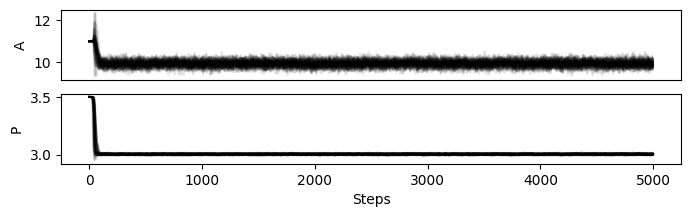

In [24]:
from simpple.plot import chainplot

chainplot(sampler.get_chain(), labels=model_fix.keys())
plt.show()

For the corner plot, we will use a dictionary to filter the parameters automatically.

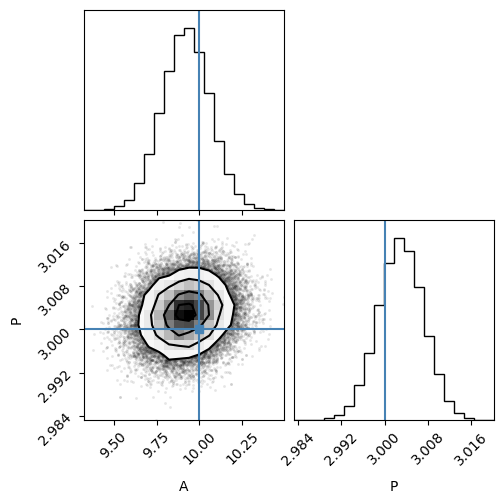

In [25]:
import corner

chain = sampler.get_chain(flat=True, discard=1000, thin=5)
chain_dict = dict(zip(model_fix.keys(), chain.T))
corner.corner(chain_dict, labels=model_fix.keys(), truths=p_true)
plt.show()

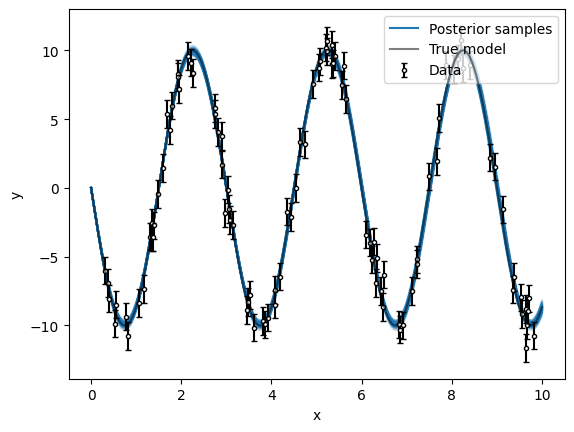

In [26]:
pred_samples = model_fix.get_posterior_pred(chain.T, 100, x_mod)
plt.plot(x_mod, pred_samples[0], "C0-", label="Posterior samples")
plt.plot(x_mod, pred_samples[1:].T, "C0-", alpha=0.2)
plot_data()
plt.show()

That's it!
Hopefully this can be useful when building complicated models for various use-cases with `simpple`.